<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7%20/BiDirectionalRNN/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import time

## ====== 1. SETUP DAN PERSIAPAN DATA ======


In [ ]:
# Mengatur seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Konfigurasi awal
max_features = 20000  # Ukuran vocabulary
maxlen = 200  # Panjang maksimum sequence
batch_size = 32
target_accuracy = 0.90  # Target akurasi 90%
max_epochs = 10  # Maksimum 10 epoch


In [ ]:
print("Loading data...")
# Load dataset IMDB
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"Training data: {len(x_train)}, Testing data: {len(x_test)}")

Loading data...
Training data: 25000, Testing data: 25000


In [ ]:
# Padding sequences
print("Padding sequences...")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Padding sequences...


In [ ]:
# Memisahkan validation set
val_split = int(len(x_train) * 0.2)
x_val = x_train[:val_split]
y_val = y_train[:val_split]
x_train = x_train[val_split:]
y_train = y_train[val_split:]

print(f"Training shape: {x_train.shape}")
print(f"Validation shape: {x_val.shape}")
print(f"Testing shape: {x_test.shape}")



Training shape: (20000, 200)
Validation shape: (5000, 200)
Testing shape: (25000, 200)


## ====== 2. DEFINISI MODEL BiRNN ======


In [ ]:
def build_birnn_model(hp=None):
    model = Sequential()

    # Layer embedding
    embedding_dim = 128 if hp is None else hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))

    # Layer BiRNN
    lstm_units = 64 if hp is None else hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = 0.5 if hp is None else hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)

    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))

    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout_rate))

    # Layer output
    model.add(Dense(1, activation='sigmoid'))

    # Kompilasi model
    learning_rate = 0.001 if hp is None else hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



## ====== 3. VISUALISASI HASIL ======


In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc



## ====== 4. EVALUASI MODEL ======


In [ ]:
def evaluate_model(model, x_test, y_test):
    y_pred_prob = model.predict(x_test, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # F1-squared metric (penyesuaian dari F1 score)
    f1_squared = f1 ** 2

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    # Plot ROC curve dan hitung AUC
    roc_auc = plot_roc_curve(y_test, y_pred_prob)

    # Menampilkan hasil evaluasi
    print("\n===== Model Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F1-Squared: {f1_squared:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_squared': f1_squared,
        'auc': roc_auc
    }


## ====== 5. HYPERPARAMETER TUNING ======

In [ ]:
def hyperparameter_tuning():
    # Custom callback untuk berhenti jika akurasi mencapai target
    class TargetAccuracyStop(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('val_accuracy') >= target_accuracy:
                print(f"\nAkurasi {target_accuracy*100}% tercapai, menghentikan training!")
                self.model.stop_training = True

    tuner = kt.Hyperband(
        build_birnn_model,
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='keras_tuner',
        project_name='imdb_birnn'
    )

    # Callbacks untuk hyperparameter tuning
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    target_stop = TargetAccuracyStop()

    # Melakukan hyperparameter search
    print("\n===== Starting Hyperparameter Tuning =====")
    tuner.search(
        x_train, y_train,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[stop_early, target_stop]
    )

    # Mendapatkan model terbaik
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("\n===== Best Hyperparameters =====")
    print(f"Embedding dimension: {best_hps.get('embedding_dim')}")
    print(f"LSTM units: {best_hps.get('lstm_units')}")
    print(f"Dropout rate: {best_hps.get('dropout_rate')}")
    print(f"Learning rate: {best_hps.get('learning_rate')}")

    # Membuat model dengan hyperparameter terbaik
    best_model = tuner.hypermodel.build(best_hps)
    return best_model, best_hps



## ====== 6. TRAINING MODEL ======


In [ ]:
def train_final_model(model):
    print("\n===== Training Final Model =====")

    # Custom callback untuk berhenti jika akurasi mencapai target
    class TargetAccuracyStop(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('val_accuracy') >= target_accuracy:
                print(f"\nAkurasi {target_accuracy*100}% tercapai, menghentikan training!")
                self.model.stop_training = True

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_birnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    target_stop = TargetAccuracyStop()

    start_time = time.time()

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=10,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, checkpoint, target_stop],
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Visualisasi history training
    plot_history(history)

    return history


## ====== 7. PREDIKSI DAN EVALUASI FINAL ======


In [ ]:
def predict_and_evaluate(model):
    print("\n===== Model Prediction and Evaluation =====")

    # Evaluasi pada training set
    print("Evaluating on training set...")
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Evaluasi pada validation set
    print("\nEvaluating on validation set...")
    val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Evaluasi pada testing set
    print("\nEvaluating on testing set...")
    test_metrics = evaluate_model(model, x_test, y_test)

    return train_accuracy, val_accuracy, test_metrics


In [ ]:
print("\n======== LANGKAH 1: HYPERPARAMETER TUNING ========")
tuned_model, best_hps = hyperparameter_tuning()


Trial 30 Complete [00h 02m 49s]
val_accuracy: 0.8712000250816345

Best val_accuracy So Far: 0.8822000026702881
Total elapsed time: 01h 02m 32s

===== Best Hyperparameters =====
Embedding dimension: 256
LSTM units: 64
Dropout rate: 0.4
Learning rate: 0.0002714550577760065



======== LANGKAH 2: TRAINING MODEL FINAL ========

===== Training Final Model =====
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6833 - loss: 0.5490
Epoch 1: val_accuracy improved from -inf to 0.88060, saving model to best_birnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.6835 - loss: 0.5488 - val_accuracy: 0.8806 - val_loss: 0.2908
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9084 - loss: 0.2333
Epoch 2: val_accuracy did not improve from 0.88060
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9085 - loss: 0.2333 - val_accuracy: 0.8734 - val_loss: 0.3445
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9492 - loss: 0.1505
Epoch 3: val_accuracy did not improve from 0.88060
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9492 - loss: 0.1505 - val_accuracy: 0.8488 - val_loss: 0.4048
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9673 - loss: 0.0987
Epoch 4: val_accuracy did not improve from 0.88060
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.9673 - loss: 0.0987 - val_accuracy: 0.8418 - val_loss: 0.4360
Training completed in 151.71 seconds


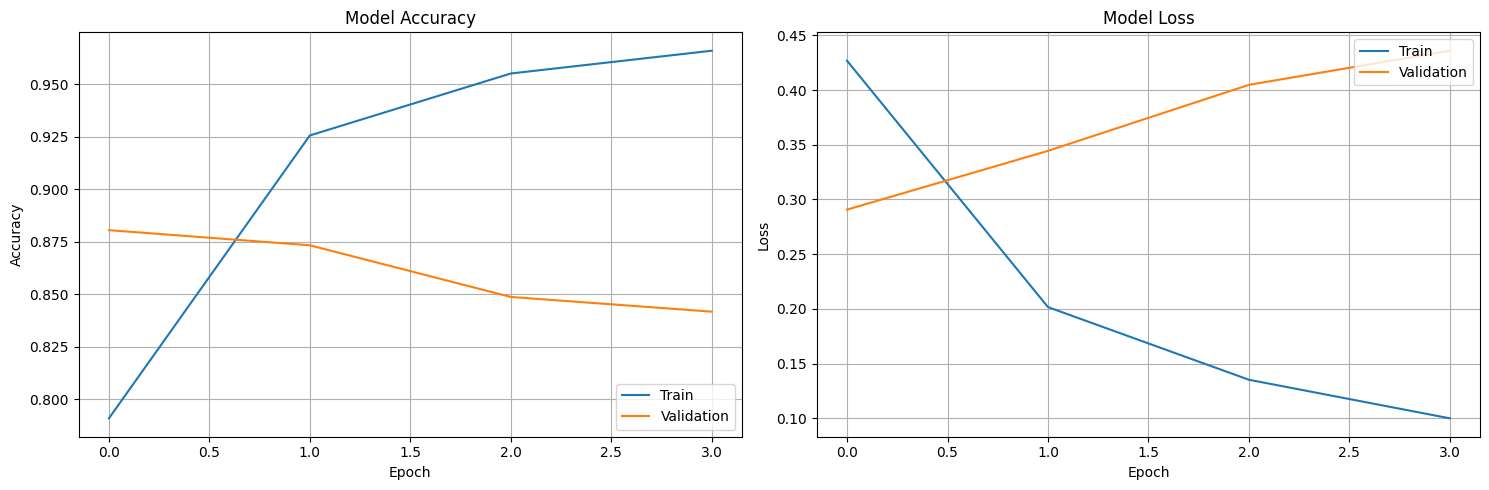

In [ ]:
print("\n======== LANGKAH 2: TRAINING MODEL FINAL ========")
history = train_final_model(tuned_model)


======== LANGKAH 3: EVALUASI MODEL ========

===== Model Prediction and Evaluation =====
Evaluating on training set...
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9415 - loss: 0.1815
Training Loss: 0.1842, Training Accuracy: 0.9396

Evaluating on validation set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8834 - loss: 0.2824
Validation Loss: 0.2908, Validation Accuracy: 0.8806

Evaluating on testing set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


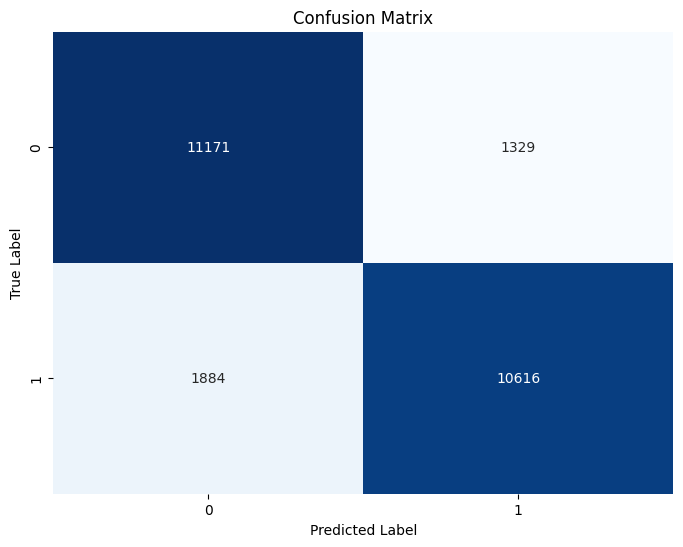

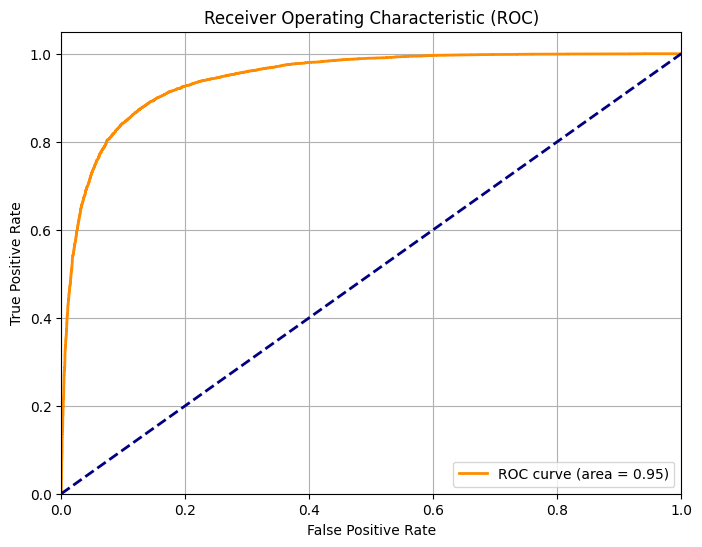


===== Model Evaluation =====
Accuracy: 0.8715
Precision: 0.8887
Recall: 0.8493
F1 Score: 0.8686
F1-Squared: 0.7544
AUC: 0.9451


In [ ]:
print("\n======== LANGKAH 3: EVALUASI MODEL ========")
train_accuracy, val_accuracy, test_metrics = predict_and_evaluate(tuned_model)


======== LANGKAH 3: EVALUASI MODEL ========

===== Model Prediction and Evaluation =====
Evaluating on training set...
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9415 - loss: 0.1815
Training Loss: 0.1842, Training Accuracy: 0.9396

Evaluating on validation set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8834 - loss: 0.2824
Validation Loss: 0.2908, Validation Accuracy: 0.8806

Evaluating on testing set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


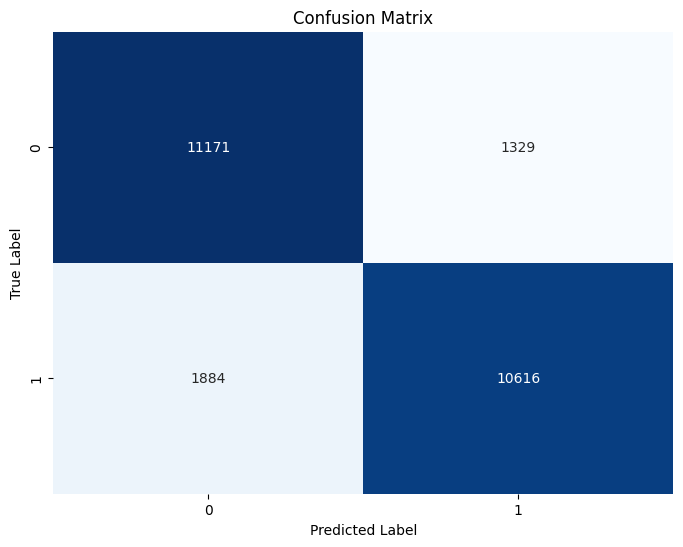

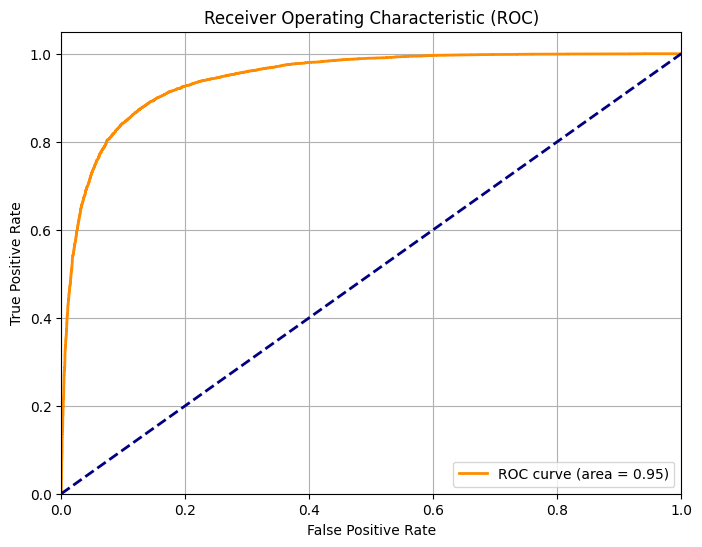


===== Model Evaluation =====
Accuracy: 0.8715
Precision: 0.8887
Recall: 0.8493
F1 Score: 0.8686
F1-Squared: 0.7544
AUC: 0.9451


In [ ]:
print("\n======== LANGKAH 3: EVALUASI MODEL ========")
train_accuracy, val_accuracy, test_metrics = predict_and_evaluate(tuned_model)

In [ ]:
print("\n======== HASIL AKHIR ========")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Testing Accuracy: {test_metrics['accuracy']:.4f}")


======== HASIL AKHIR ========
Training Accuracy: 0.9396
Validation Accuracy: 0.8806
Testing Accuracy: 0.8715
